In [50]:
import pickle
from sklearn.cross_validation import train_test_split

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.learning_curve import learning_curve
import xgboost as xgb

from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline

# import warnings
# warnings.filterwarnings("ignore")


In [59]:
X = pickle.load(open('data/X.pickle', 'rb'))
y = pickle.load(open('data/y.pickle', 'rb'))


## Use L1 penalty to select features

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

logit = LogisticRegression(penalty='l1')
logit.fit(X_train, y_train)
# l = [(x, y) for (x, y) in zip(X.columns, logit.coef_[0,:]) if y!=0]
# print(l)
l = []
for i in range(len(Counter(y))):
    l.extend([x for x, y in zip(X.columns, logit.coef_[i,:]) if y!=0])

X_trim = X[list(set(l))]


In [61]:
corr_matrix.shape

(21, 21)

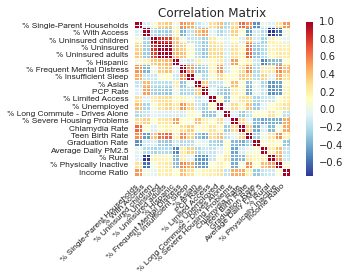

In [51]:
import statsmodels.api as sm
import numpy as np

corr_matrix = np.corrcoef(X_trim.values.T)
sm.graphics.plot_corr(corr_matrix, list(X_trim.columns.values));

## Train models

In [62]:
nb = GaussianNB()
svc = SVC(probability=True)
dtc = DecisionTreeClassifier()
rfc = RandomForestClassifier()
logit = LogisticRegression()
gbtr = GradientBoostingClassifier()
gbm = xgb.XGBClassifier(max_depth=3, n_estimators=300, learning_rate=0.05)

model_names = ['Naive Bayers', 'SVM', 'Random Forest', 'Logistic', 'GBboost', 'XGBoost']
models = [nb, svc, dtc, rfc, logit, gbtr, gbm]
for name, model in zip(model_names, models):
    model.fit(X_train, y_train)
    # print(name + ': %6.4f' % accuracy_score(model.predict(X_test), y_test))
    print(name)
    print(classification_report(y_test, model.predict(X_test)))

Naive Bayers
             precision    recall  f1-score   support

        +7%       0.43      0.72      0.54        18
       0-4%       0.81      0.71      0.76       208
       4-7%       0.42      0.32      0.36        60
   negative       0.18      0.39      0.24        23

avg / total       0.66      0.61      0.63       309

SVM
             precision    recall  f1-score   support

        +7%       0.00      0.00      0.00        18
       0-4%       0.67      1.00      0.80       208
       4-7%       0.00      0.00      0.00        60
   negative       0.00      0.00      0.00        23

avg / total       0.45      0.67      0.54       309

Random Forest
             precision    recall  f1-score   support

        +7%       0.40      0.22      0.29        18
       0-4%       0.76      0.79      0.77       208
       4-7%       0.35      0.38      0.37        60
   negative       0.00      0.00      0.00        23

avg / total       0.60      0.62      0.61       309

Logist

In [372]:
urban_df = pd.read_csv('data/urban_sprawl.csv')
urban_df.drop('composite', axis=1, inplace=True)


health_data = pd.read_csv('data/health_data.csv')
health_data.drop(['State', 'County'], axis=1, inplace=True)

health_add = pd.read_csv('data/health_add.csv')
death_cols = [col for col in health_add.columns if 'Mortality' in col]
health_add.drop(death_cols, axis=1, inplace=True)
health_df = pd.merge(health_data, health_add, on='FIPS')

In [373]:
trends = pd.read_csv('data/trends.csv')
obesity = trends[['yearspan', 'measurename', 'statecode', 'countycode','rawvalue']]
obesity = obesity[obesity['countycode']>0]
obesity_last = obesity[(obesity['measurename']=='Adult obesity') & (obesity['yearspan'].isin(['2003-2005']))]
obesity_current = obesity[(obesity['measurename']=='Adult obesity') & (obesity['yearspan'].isin(['2011-2013']))]
obesity_last.rename(columns={'rawvalue': 'last'}, inplace=True)
obesity_current.rename(columns={'rawvalue': 'current'}, inplace=True)

In [374]:
coordinates = pickle.load(open('data/coordinates.pickle', 'rb'))
coo_df = coordinates[[2,12,13]]
coo_df.columns = ['FIPS', 'Lat', 'Long']
coo_df = coo_df[coo_df['FIPS']!=8014]
coo_df['Lat'] = coo_df['Lat'].apply(lambda x: float(x[1:-1]) if len(x)>2 else 0)
coo_df['Long'] = coo_df['Long'].apply(lambda x: -float(x[1:-1]) if len(x)>2 else 0)


In [375]:
obesity = pd.merge(obesity_last, obesity_current, on=['statecode', 'countycode'])
obesity['change'] = obesity['current'] - obesity['last']
obesity['FIPS'] = obesity['statecode']*1000+obesity['countycode']

ho_df = pd.merge(health_df, obesity, on=['FIPS'])
ho_df = pd.merge(ho_df, coo_df, on = ['FIPS'])
hou_df = pd.merge(ho_df, urban_df, on=['FIPS'])

In [376]:
delta = ho_df['change']
pct_obese = ho_df['% Obese']

# delta = hou_df['change']
obese_cols = obesity.columns
# other_cols = ['Presence of violation', '% <18', '% Obese']
other_cols = ['Presence of violation', '% <18']
# other_cols += ['Name', 'MSA']
X = ho_df.drop(['FIPS', 'State', 'County']+list(obese_cols)+list(other_cols), axis=1)
X['random'] = np.random.randn(X.shape[0], 1)
# X = hou_df.drop(['FIPS', 'State', 'County']+list(obese_cols)+list(other_cols), axis=1)
X = X.apply(lambda x: x.fillna(x.median()))
X = X.apply(lambda x: (x - x.mean())/(x.max()-x.min()))

In [353]:
X.shape

(3140, 63)

In [377]:
# cutoffs = [np.percentile(delta, 25), np.percentile(delta, 50), np.percentile(delta, 75)]
cutoffs = [np.percentile(pct_obese, 25), np.percentile(pct_obese, 50), np.percentile(pct_obese, 75)]

def label(x, cut1, cut2, cut3):
    if x < cut1:
        return 'slim'
    elif x < cut2:
        return 'acceptable'
    elif x < cut3:
        return 'fat'
    else:
        return 'obese'

# y = delta.apply(label, args=cutoffs)
y = pct_obese.apply(label, args=cutoffs)   

[29.0, 31.0, 34.0]

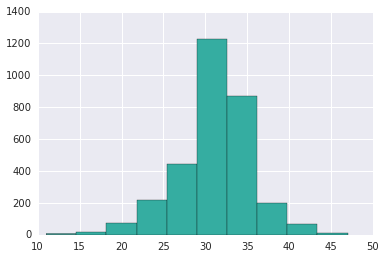

In [390]:
plt.hist(pct_obese)
cutoffs

In [378]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


logit = LogisticRegression(penalty='l1')
logit.fit(X_train, y_train)

l = []
for i in range(len(Counter(y))):
    l.extend([x for x, y in zip(X.columns, logit.coef_[i,:]) if y!=0])

X_trim = X[list(set(l))]

In [368]:
X_trim.shape


(3140, 53)

In [391]:
nb = GaussianNB()
svc = SVC(probability=True)
rfc = RandomForestClassifier()
logit = LogisticRegression(penalty='l1')
gbtr = GradientBoostingClassifier()
gbm = xgb.XGBClassifier(max_depth=3, n_estimators=300, learning_rate=0.05)

model_names = ['Naive Bayers', 'SVM','Random Forest', 'Logistic','Gradient Boosting','XGBoost']
models = [nb, svc, rfc, logit, gbtr, gbm]

# model_names = ['Naive Bayers', 'Random Forest', 'Logistic', 'XGBoost']
# models = [nb, rfc, logit, gbm]

for name, model in zip(model_names, models):
    model.fit(X_train, y_train)
    print(name + ': %6.4f' % accuracy_score(y_test, model.predict(X_test)))
    print(name)
    print(classification_report(y_test, model.predict(X_test)))

Naive Bayers: 0.7325
Naive Bayers
             precision    recall  f1-score   support

 acceptable       0.75      0.68      0.71       175
        fat       0.74      0.65      0.69       282
      obese       0.68      0.78      0.73       255
       slim       0.78      0.82      0.80       230

avg / total       0.73      0.73      0.73       942

SVM: 0.5881
SVM
             precision    recall  f1-score   support

 acceptable       0.00      0.00      0.00       175
        fat       0.44      0.77      0.56       282
      obese       0.75      0.68      0.71       255
       slim       0.75      0.72      0.73       230

avg / total       0.52      0.59      0.54       942

Random Forest: 0.9140
Random Forest
             precision    recall  f1-score   support

 acceptable       0.85      0.87      0.86       175
        fat       0.86      0.90      0.88       282
      obese       0.96      0.92      0.94       255
       slim       0.98      0.95      0.97       230

avg /

In [366]:
gbm = xgb.XGBClassifier()
gbm.fit(X_train, y_train)

feature_names = X.columns
l = [(x, y) for (x, y) in zip(feature_names, gbm.feature_importances_)]
thresholds = sorted(l, key=lambda x: x[1], reverse=True)
# [print(f) for f in thresholds];
cut_index = [f for f, _ in thresholds].index('random')
print('number of features more important than noise %d:' % cut_index)

selected_features = [f for f, _ in thresholds][:cut_index]
select_X_train = X_train[selected_features]
select_X_test = X_test[selected_features]

gbm = xgb.XGBClassifier()
gbm.fit(select_X_train, y_train)
predictions = gbm.predict(select_X_test)
accuracy = accuracy_score(y_test, predictions)
print('accuracy after triming useless features: %6.4f' % accuracy)

number of features more important than noise 27:
accuracy after triming useless features: 0.5743


[[ 28  87  16  44]
 [ 19 169  73  21]
 [  4  79 170   2]
 [ 15  36   3 176]]
             precision    recall  f1-score   support

 acceptable       0.42      0.16      0.23       175
        fat       0.46      0.60      0.52       282
      obese       0.65      0.67      0.66       255
       slim       0.72      0.77      0.74       230

avg / total       0.57      0.58      0.56       942



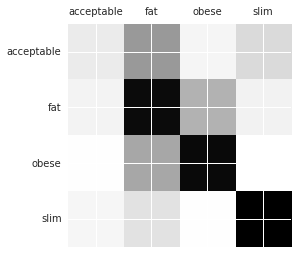

In [370]:
import sklearn.metrics as skm
X_train = select_X_train
X_test = select_X_test
gbm.fit(X_train,y_train)
cm = skm.confusion_matrix(y_test, gbm.predict(X_test))
print(cm)
print(skm.classification_report(y_test, gbm.predict(X_test)))

fig, ax = plt.subplots()
ax.matshow(cm)
# plt.colorbar()
ax.set_xticklabels(['']+list(gbm.classes_));
ax.set_yticklabels(['']+list(gbm.classes_));


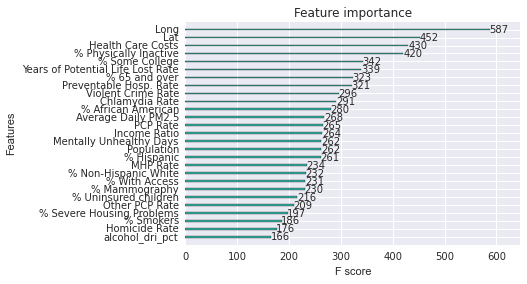

In [371]:
from xgboost import plot_importance
plot_importance(gbm);

In [319]:
from sklearn.feature_selection import SelectFromModel
predictions = gbm.predict(X_test)

accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
# Fit model using each importance as a threshold
thresholds = sorted(gbm.feature_importances_)
for thresh in thresholds[30:]:
    # select features using threshold
    selection = SelectFromModel(gbm, threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_train)
    # train model
    selection_model = xgb.XGBClassifier()
    selection_model.fit(select_X_train, y_train)
    # eval model
    select_X_test = selection.transform(X_test)
    predictions = selection_model.predict(select_X_test)
    accuracy = accuracy_score(y_test, predictions)
    print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_X_train.shape[1], accuracy*100.0))


Accuracy: 57.01%
Thresh=0.014, n=33, Accuracy: 56.69%
Thresh=0.014, n=32, Accuracy: 56.79%
Thresh=0.014, n=31, Accuracy: 57.43%
Thresh=0.015, n=30, Accuracy: 57.01%
Thresh=0.015, n=30, Accuracy: 57.01%
Thresh=0.015, n=28, Accuracy: 56.26%
Thresh=0.015, n=27, Accuracy: 56.58%
Thresh=0.015, n=26, Accuracy: 55.73%
Thresh=0.016, n=25, Accuracy: 57.32%
Thresh=0.017, n=24, Accuracy: 56.37%
Thresh=0.017, n=23, Accuracy: 57.86%
Thresh=0.017, n=22, Accuracy: 57.32%
Thresh=0.019, n=21, Accuracy: 57.75%
Thresh=0.019, n=20, Accuracy: 57.22%
Thresh=0.019, n=20, Accuracy: 57.22%
Thresh=0.020, n=18, Accuracy: 56.69%
Thresh=0.021, n=17, Accuracy: 56.69%
Thresh=0.021, n=16, Accuracy: 57.22%
Thresh=0.021, n=15, Accuracy: 56.16%
Thresh=0.022, n=14, Accuracy: 56.48%
Thresh=0.023, n=13, Accuracy: 56.48%
Thresh=0.023, n=12, Accuracy: 56.79%
Thresh=0.023, n=11, Accuracy: 55.52%
Thresh=0.026, n=10, Accuracy: 55.20%
Thresh=0.026, n=9, Accuracy: 55.31%
Thresh=0.027, n=8, Accuracy: 55.52%
Thresh=0.030, n=7, Accu

In [318]:
feature_names = X.columns
l = [(x, y) for (x, y) in zip(feature_names, gbm.feature_importances_)]
sort_l = sorted(l, key=lambda x: x[1], reverse=True)
[print(f) for f in sort_l];


('Long', 0.049480837)
('% Physically Inactive', 0.047429815)
('Average Daily PM2.5', 0.033713628)
('Lat', 0.031790797)
('Health Care Costs', 0.031021664)
('Population', 0.029611588)
('% 65 and over', 0.029611588)
('Chlamydia Rate', 0.02653506)
('Violent Crime Rate', 0.026278682)
('PCP Rate', 0.025894117)
('% Some College', 0.023330342)
('Years of Potential Life Lost Rate', 0.023202153)
('% African American', 0.022817587)
('Preventable Hosp. Rate', 0.022304833)
('random', 0.021279324)
('% Smokers', 0.021151135)
('% With Access', 0.021022946)
('Income Ratio', 0.020253813)
('MHP Rate', 0.019356493)
('% Uninsured children', 0.019356493)
('% Non-Hispanic White', 0.019100115)
('Other PCP Rate', 0.017049097)
('alcohol_dri_pct', 0.016792718)
('% Mammography', 0.016664531)
('% Hispanic', 0.016408153)
('Mentally Unhealthy Days', 0.015382643)
('Injury Death Rate', 0.014998077)
('% Drive Alone', 0.0147417)
('% Severe Housing Problems', 0.014613511)
('Homicide Rate', 0.014613511)
('% Insufficient S